<a href="https://colab.research.google.com/github/rhapsodic-legacy/streamflow_prediction/blob/main/streamflow_time_series_205.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multivariate Time Series Flood Prediction
##### Ten Day Forecast, Top 10 Watersheds (rated by discharge value availability in the last 20 years of that watershed's recordings). 

### Phase One: Isolating the correct data to build a model upon. 
##### Each watershed has differing characteristics, so any given model prediction will be for a certain watershed. The target variable that directly correlates to a flood, is 'discharge'. 
##### Some watersheds have most of their discharge values available for model training, most have many missing values, and some are missing more than 90% of their discharge values. This is due to varying factors. 
#### For Watershed 8, this model's sMAPE score is: 32.18931624946136

In [1]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import relevant libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math, time
import sklearn as sk

In [3]:
# Copy this file to a local drive. In this case, Google Drive. 
!cp /content/drive/MyDrive/Kalman_Filter/top_ten_watersheds.csv /content/

In [4]:
df = pd.read_csv('top_ten_watersheds.csv')
df.head()

,time,watershed,pr,tasmax,tasmin,discharge
0,1950-01-01,175,0.966122,-21.574120,-27.607310,NaN
1,1950-01-02,175,1.008771,-25.995184,-31.368013,NaN
2,1950-01-03,175,0.000000,-28.295700,-38.181858,NaN
3,1950-01-04,175,0.000000,-26.836973,-39.946175,NaN
4,1950-01-05,175,0.000000,-29.592003,-37.728634,NaN


In [5]:
df.watershed.unique()

array([175,   8, 205, 159, 252, 110, 214,  27, 147, 236])

### Phase Two: Data Cleaning and Feature Selection

In [52]:
# As watershed 8 had the second most discharge values, it will be explored. 
shed205 = df[(df['watershed'] == 205)]
shed205.tail()

,time,watershed,pr,tasmax,tasmin,discharge
75601,2018-12-27,205,0.090814,-11.948434,-24.337683,NaN
75602,2018-12-28,205,0.774530,-13.610543,-28.897703,NaN
75603,2018-12-29,205,1.222965,-11.126410,-16.638727,NaN
75604,2018-12-30,205,0.000000,-14.512943,-27.781420,NaN
75605,2018-12-31,205,0.047808,-23.593946,-34.732567,NaN


In [53]:
# It seems watershed 8 has null values towards the end of its readings. 
# Observe when the last recorded discharge value was. 
copy = shed205.copy()
copy.dropna(inplace=True)
copy.tail()

,time,watershed,pr,tasmax,tasmin,discharge
74871,2016-12-27,205,1.170564,-10.097390,-22.942066,2.64
74872,2016-12-28,205,0.929019,-3.541023,-14.312735,2.65
74873,2016-12-29,205,0.000000,-6.199687,-16.686535,2.61
74874,2016-12-30,205,0.926618,-10.480793,-16.324427,2.52
74875,2016-12-31,205,0.000000,-7.759708,-13.571190,2.57


In [54]:
# We will be focusing on the past twentyfive years of data. 
# As 2016 was the last year of recordings, 1992 forward will be taken. 
shed205 = shed205[(shed205['time'] > '1991-12-31') & (shed205['time'] < '2017-01-01')]

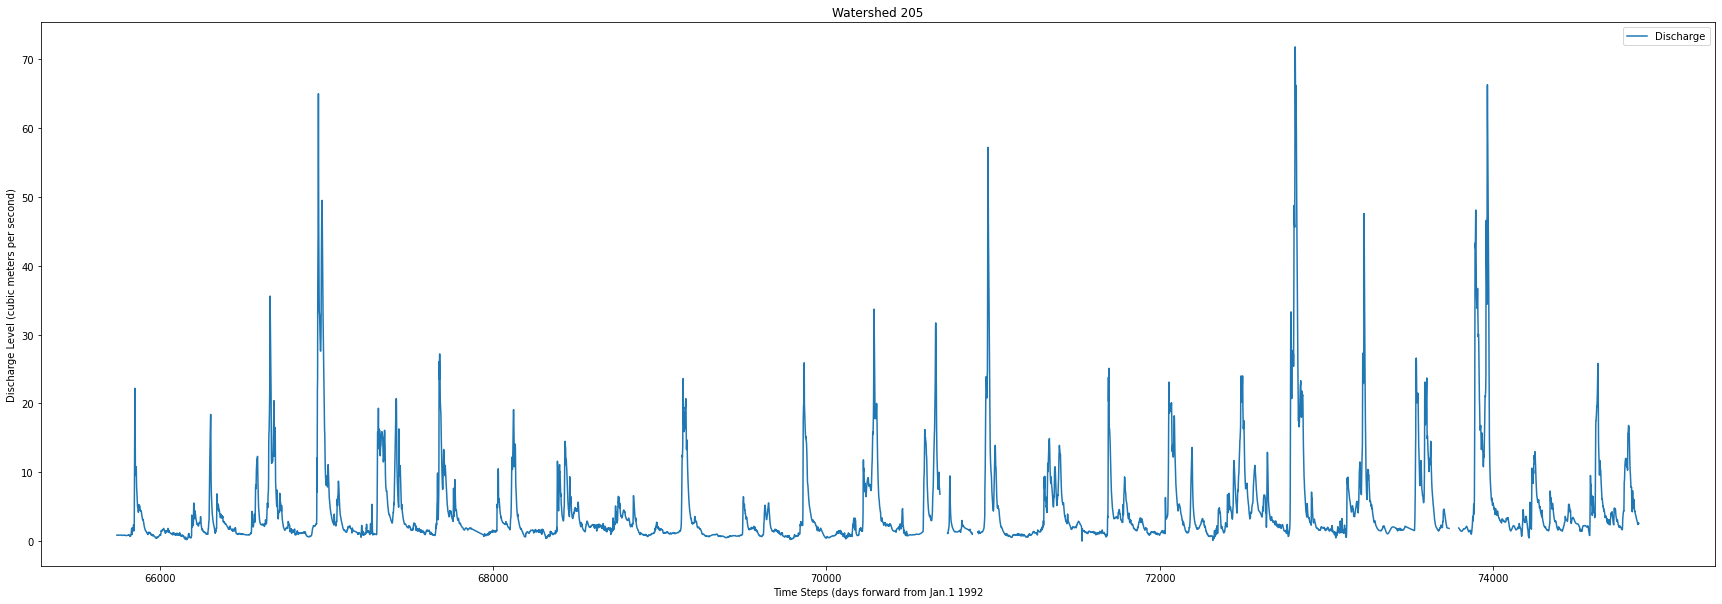

In [55]:
# For visual representation, plotting discharge of watershed 205
x = range(len(shed205))
y = shed205.discharge

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 205")
plt.xlabel("Time Steps (days forward from Jan.1 1992")
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y, label = 'Discharge')

plt.legend()
plt.show()

In [56]:
# There doesn't appear to be many missing discharge values. 
# Measure how many NaN's there are. 
shed205.isna().sum()

time           0
watershed      0
pr             0
tasmax         0
tasmin         0
discharge    135
dtype: int64

In [57]:
# For this watershed, the missing values do not acrue near peak discharge moments. 
# Using Pandas built in function 'interpolate', nan values will be filled in. 

# Switching the 'time' column to the datetime format.
shed205["time"] = pd.to_datetime(shed205["time"])

In [58]:
shed205.set_index('time', inplace = True)
for watershedID in set(shed205["watershed"]):
  shed205[shed205["watershed"] == watershedID] = shed205[shed205["watershed"] == watershedID].interpolate(method='time', axis=0, limit_direction="both")

In [59]:
# For purposes of ease of experimentation, a copy will be made of the dataframe. 
model = shed205.copy()

In [62]:
# Herein we will create a function that creates represenations of the past days. 
# And A fortnight is the target variable. --> This can be changed to 10 days out, instead of 14. 

def advance(x):
  num_list = []
  length = len(model.discharge)
  for i in range(length):
    if x + i >= length: # For calculating the target variable
      num = i
    elif i + x < 0: # For calculating the past. 
      num = i
    else:
      num = i + x # Other than the outliers, the value will be discharge[i + 'x']
    forecast = model['discharge'][num]
    num_list.append(forecast)
  name = f"discharge_{x}"    
  model[name] = num_list #model1['discharge'][num]

In [61]:
# The target forecast was identified as 10 days, by a NRCan representative. 
advance(10)
model.head()

,watershed,pr,tasmax,tasmin,discharge,discharge_10
time,,,,,,
1992-01-01,205,0.000000,-6.908142,-12.661796,0.86,0.87
1992-01-02,205,0.000000,0.098121,-16.329853,0.85,0.87
1992-01-03,205,0.000000,1.084551,-14.154489,0.86,0.86
1992-01-04,205,0.000000,-2.235386,-15.109603,0.85,0.86
1992-01-05,205,0.706054,-5.627348,-11.886221,0.86,0.86


In [63]:
# Next a column representing the past week's cumulative rainfall. 

def rainfall(x):
  rainfall = []
  length = len(model.discharge)
  for i in range(length):
    # In this case, we're only interested in the past rainfall. 
    if i + x < 0:
      answer = model.pr[:i+1].sum()
    else:
      num = i + x
      answer = model.pr[num:i].sum()
    rainfall.append(answer)
  name = f"pr_{x}"
  model[name] = rainfall
  

In [64]:
rainfall(-7)
model.head()

,watershed,pr,tasmax,tasmin,discharge,discharge_10,pr_-7
time,,,,,,,
1992-01-01,205,0.000000,-6.908142,-12.661796,0.86,0.87,0.000000
1992-01-02,205,0.000000,0.098121,-16.329853,0.85,0.87,0.000000
1992-01-03,205,0.000000,1.084551,-14.154489,0.86,0.86,0.000000
1992-01-04,205,0.000000,-2.235386,-15.109603,0.85,0.86,0.000000
1992-01-05,205,0.706054,-5.627348,-11.886221,0.86,0.86,0.706054


In [66]:
# For the purposes of this iteration of the model, only precipitation and discharge values will be kept. 
model = model.drop(['watershed', 'tasmax', 'tasmin'], axis=1)

### Phase Three: Building the Multivariate Time Series Model


In [67]:
time_shift = 10

target_data = model['discharge'].shift(time_shift)
data = model.iloc[:-time_shift]
data

,pr,discharge,discharge_10,pr_-7
time,,,,
1992-01-01,0.000000,0.86,0.87,0.000000
1992-01-02,0.000000,0.85,0.87,0.000000
1992-01-03,0.000000,0.86,0.86,0.000000
1992-01-04,0.000000,0.85,0.86,0.000000
1992-01-05,0.706054,0.86,0.86,0.706054
...,...,...,...,...
2016-12-17,0.000000,3.29,2.64,0.183716
2016-12-18,1.188727,3.20,2.65,0.000000
2016-12-19,1.088935,3.10,2.61,1.188727


In [68]:
test_head = data.index[int(0.75*len(data))]
test_head

Timestamp('2010-09-24 00:00:00')

In [69]:
df_train = data.loc[:test_head,:]
df_test = data.loc[test_head:,:]
target_train = target_data.loc[:test_head]
target_test = target_data.loc[test_head:]

In [70]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [71]:
i = 27
sequence_length = 10
features = ['pr', 'discharge', 'pr_-7']
target = 'discharge_10'

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[0.0000, 0.8500, 6.7977],
        [0.0000, 0.8500, 4.6175],
        [0.0000, 0.8600, 4.4344],
        [2.6310, 0.8600, 4.4344],
        [0.0000, 0.8700, 4.4139],
        [1.8457, 0.8800, 3.4187],
        [1.4587, 0.8700, 5.2644],
        [1.4534, 0.8700, 5.9354],
        [0.0000, 0.8700, 7.3888],
        [0.1587, 0.8800, 7.3888]])


In [72]:
from torch.utils.data import DataLoader
torch.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([3, 10, 3])
tensor([[[0.0000e+00, 1.1700e+00, 1.1207e+00],
         [0.0000e+00, 1.1900e+00, 1.1207e+00],
         [0.0000e+00, 1.1000e+00, 1.1207e+00],
         [0.0000e+00, 2.1300e+00, 1.0188e-01],
         [0.0000e+00, 4.3500e+00, 1.0188e-01],
         [0.0000e+00, 5.3400e+00, 1.0188e-01],
         [0.0000e+00, 5.0100e+00, 1.0188e-01],
         [0.0000e+00, 3.3300e+00, 0.0000e+00],
         [0.0000e+00, 1.7300e+00, 0.0000e+00],
         [5.7411e-02, 1.1400e+00, 0.0000e+00]],

        [[0.0000e+00, 1.3600e+00, 4.0658e+00],
         [0.0000e+00, 1.3600e+00, 3.8035e+00],
         [0.0000e+00, 1.3700e+00, 3.8035e+00],
         [2.6618e+00, 1.3800e+00, 1.5718e+00],
         [5.0397e-01, 1.4100e+00, 2.8914e+00],
         [5.7411e-02, 1.4400e+00, 3.1658e+00],
         [1.5929e-01, 1.4400e+00, 3.2232e+00],
         [3.1969e+00, 1.4500e+00, 3.3825e+00],
         [3.0714e+00, 1.4800e+00, 6.5793e+00],
         [3.0167e-01, 1.5100e+00, 9.6507e+00]],

        [[1.4969e+00, 2.7100e+00,

In [73]:
batch_size = 4
sequence_length = 10

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 10, 3])
Target shape: torch.Size([4])


In [74]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [75]:
learning_rate = 5e-5
num_hidden_units = 64

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [76]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(50):
    
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 116.86935733224799

Epoch 0
---------
Train loss: 31.352677777200537
Test loss: 83.97439564927909

Epoch 1
---------
Train loss: 22.68051229644412
Test loss: 71.90277439750622

Epoch 2
---------
Train loss: 19.669955738215403
Test loss: 65.75347814653747

Epoch 3
---------
Train loss: 18.054821251893188
Test loss: 61.52973424516026

Epoch 4
---------
Train loss: 16.867053844587694
Test loss: 58.44626407291832

Epoch 5
---------
Train loss: 15.967553624373815
Test loss: 56.072304056764494

Epoch 6
---------
Train loss: 15.266597614863649
Test loss: 53.928088998581764

Epoch 7
---------
Train loss: 14.729535967973781
Test loss: 52.08712244783224

Epoch 8
---------
Train loss: 14.26229132779709
Test loss: 50.42732786965326

Epoch 9
---------
Train loss: 13.897216603474519
Test loss: 49.16241617841567

Epoch 10
---------
Train loss: 13.577973634249535
Test loss: 48.096348333133356

Epoch 11
---------
Train loss: 13.315669487607689
Test loss: 47.2374988101

In [77]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

# for c in df_out.columns:
#     df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


            discharge_10  Model forecast
time                                    
1992-01-01          0.87        1.078161
1992-01-02          0.87        1.069036
1992-01-03          0.86        1.072689
1992-01-04          0.86        1.066153
1992-01-05          0.86        1.129275
...                  ...             ...
2016-12-17          2.64        3.793216
2016-12-18          2.65        4.033621
2016-12-19          2.61        4.268977
2016-12-20          2.52        4.296112
2016-12-21          2.57        4.360230

[9123 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


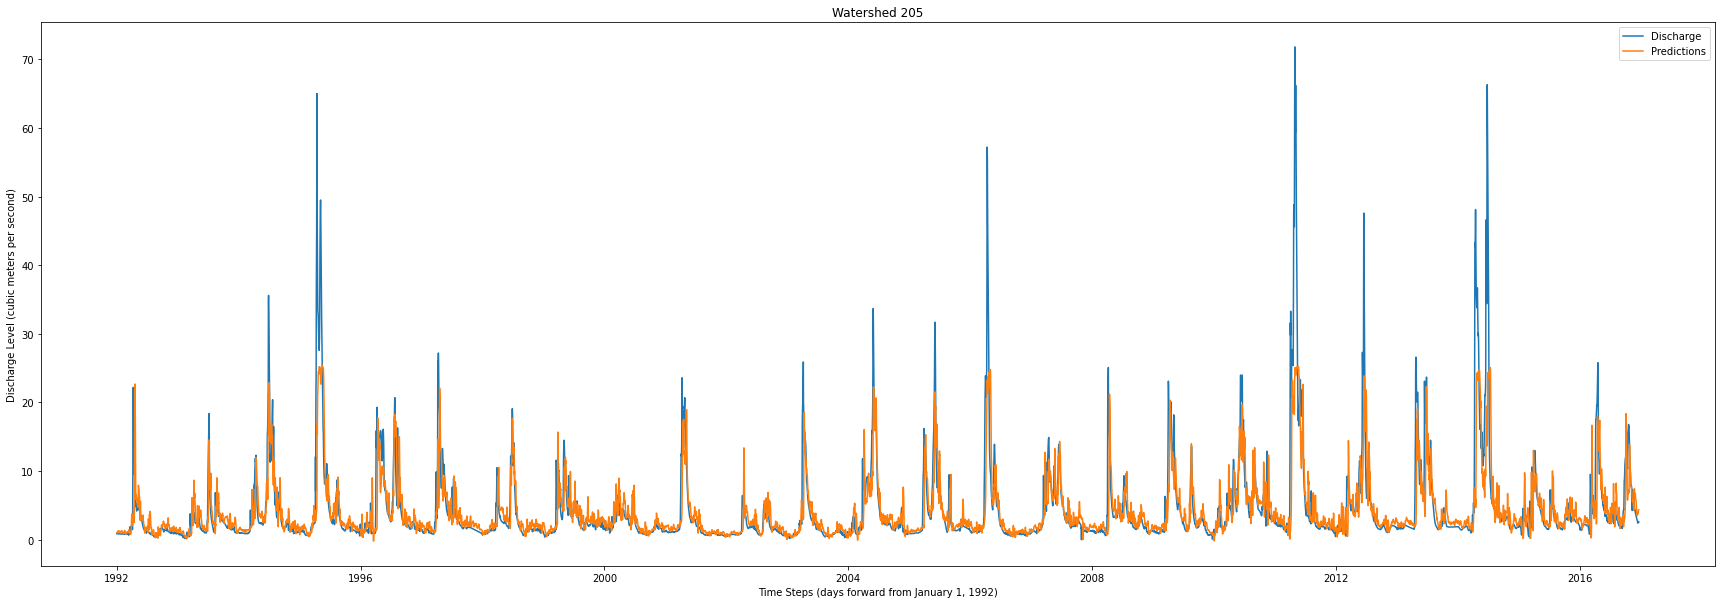

In [80]:
# For visual representation, plotting discharge of watershed 8

x = range(len(df_out))
y1 = df_out.discharge_10
y2 = df_out['Model forecast']

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 205")
plt.xlabel("Time Steps (days forward from January 1, 1992)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y1, label = 'Discharge')
plt.plot(y2, label = 'Predictions')

plt.legend()
plt.show()

In [79]:
# We are using SMAPE to measure the performance of our models. 
total = 0
for i in range(len(df_out)):
  predict = df_out['Model forecast'][i]
  recorded = df_out.discharge_10[i]
  top = np.abs(predict - recorded)
  bottom = ((predict + recorded)/2)
  answer = top/bottom
  total += answer
smape = total/len(df_out) * 100
print("For Watershed 8, this model's sMAPE score is:", smape)

For Watershed 8, this model's sMAPE score is: 38.03111443823694


In [ ]:
# Plotting the loss scores, both training and test. 

x = range(len(shed175))
y1 = df_out.discharge_10
y2 = df_out['Model forecast']

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 175")
plt.xlabel("Time Steps (days forward from January 1, 1994)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y1, label = 'Discharge')
plt.plot(y2, label = 'Predictions')

plt.legend()
plt.show()